In [50]:
if (!"BiocManager" %in% rownames(installed.packages()))
     install.packages("BiocManager")
BiocManager::install("BiocFileCache", dependencies=TRUE)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.16), R 4.0.5 (2021-03-31)

Warning message:
"package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'BiocFileCache'"
Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    boot, class, KernSmooth, lattice, MASS, mgcv, nlme, nnet, spatial, survival
  path: /usr/local/lib/R/site-library
  packages:
    ade4, ape, beeswarm, BH, BiocManager, blob, bookdown, brio, bslib, cachem,
    Cairo, cicero, circlize, ClassDiscovery, cli, clue, ClusterR, colorspace,
    conflicted, conos, conquer, corrplot, crayon, credentials, crosstalk, crul,
    curl, data.table, DBI, deldir, dendextend, desc, DescTools, dials, diffobj,
    dplyr, dqrng, drat, DT, dtplyr, e1071, entropy, Exact, fansi, fastcluster,
    fastIC

In [51]:
library(BiocFileCache)

In [48]:
# Libraries
suppressPackageStartupMessages({
    library(Seurat)
    library(patchwork)
    library(dplyr)
    library(ggplot2)
    library(sctransform)
    
    
    library(DropletUtils)
    library(SingleCellExperiment)
    library(scater)
    library(Matrix)
    library(tidyverse)
    library(BiocFileCache)
    library(rtracklayer)
    options(stringsAsFactors = FALSE)
    
})

In [40]:
library(DropletUtils)
sce <- read10xCounts("data/filtered_gene_bc_matrices/hg19/")
sce

class: SingleCellExperiment 
dim: 32738 2700 
metadata(1): Samples
assays(1): counts
rownames(32738): ENSG00000243485 ENSG00000237613 ... ENSG00000215616
  ENSG00000215611
rowData names(2): ID Symbol
colnames: NULL
colData names(2): Sample Barcode
reducedDimNames(0):
altExpNames(0):

In [41]:
colData(sce)

DataFrame with 2700 rows and 2 columns
                     Sample          Barcode
                <character>      <character>
1    data/filtered_gene_b.. AAACATACAACCAC-1
2    data/filtered_gene_b.. AAACATTGAGCTAC-1
3    data/filtered_gene_b.. AAACATTGATCAGC-1
4    data/filtered_gene_b.. AAACCGTGCTTCCG-1
5    data/filtered_gene_b.. AAACCGTGTATGCG-1
...                     ...              ...
2696 data/filtered_gene_b.. TTTCGAACTCTCAT-1
2697 data/filtered_gene_b.. TTTCTACTGAGGCA-1
2698 data/filtered_gene_b.. TTTCTACTTCCTCG-1
2699 data/filtered_gene_b.. TTTGCATGAGAGGC-1
2700 data/filtered_gene_b.. TTTGCATGCCTCAC-1

In [42]:
sce <- scuttle::addPerCellQC(sce)
colData(sce)

DataFrame with 2700 rows and 5 columns
                     Sample          Barcode       sum  detected     total
                <character>      <character> <numeric> <integer> <numeric>
1    data/filtered_gene_b.. AAACATACAACCAC-1      2421       781      2421
2    data/filtered_gene_b.. AAACATTGAGCTAC-1      4903      1352      4903
3    data/filtered_gene_b.. AAACATTGATCAGC-1      3149      1131      3149
4    data/filtered_gene_b.. AAACCGTGCTTCCG-1      2639       960      2639
5    data/filtered_gene_b.. AAACCGTGTATGCG-1       981       522       981
...                     ...              ...       ...       ...       ...
2696 data/filtered_gene_b.. TTTCGAACTCTCAT-1      3461      1155      3461
2697 data/filtered_gene_b.. TTTCTACTGAGGCA-1      3447      1227      3447
2698 data/filtered_gene_b.. TTTCTACTTCCTCG-1      1684       622      1684
2699 data/filtered_gene_b.. TTTGCATGAGAGGC-1      1024       454      1024
2700 data/filtered_gene_b.. TTTGCATGCCTCAC-1      1985       

In [53]:
class(counts(sce))

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

In [54]:
# Annotating the rows
library(scater)
rownames(sce) <- uniquifyFeatureNames(rowData(sce)$ID, rowData(sce)$Symbol)
head(rownames(sce))

[1] "MIR1302-10"   "FAM138A"      "OR4F5"        "RP11-34P13.7" "RP11-34P13.8"
[6] "AL627309.1"

In [55]:
sce

class: SingleCellExperiment 
dim: 32738 2700 
metadata(1): Samples
assays(1): counts
rownames(32738): MIR1302-10 FAM138A ... AC002321.2 AC002321.1
rowData names(2): ID Symbol
colnames: NULL
colData names(5): Sample Barcode sum detected total
reducedDimNames(0):
altExpNames(0):

In [56]:
# We can also identify the chromosomal location for each gene
library(EnsDb.Hsapiens.v75) #86
location <- mapIds(EnsDb.Hsapiens.v75, keys=rowData(sce)$ID, 
    column="SEQNAME", keytype="GENEID")
rowData(sce)$CHR <- location

In [73]:
sce

class: SingleCellExperiment 
dim: 32738 2700 
metadata(1): Samples
assays(1): counts
rownames(32738): MIR1302-10 FAM138A ... AC002321.2 AC002321.1
rowData names(3): ID Symbol CHR
colnames: NULL
colData names(5): Sample Barcode sum detected total
reducedDimNames(0):
altExpNames(0):

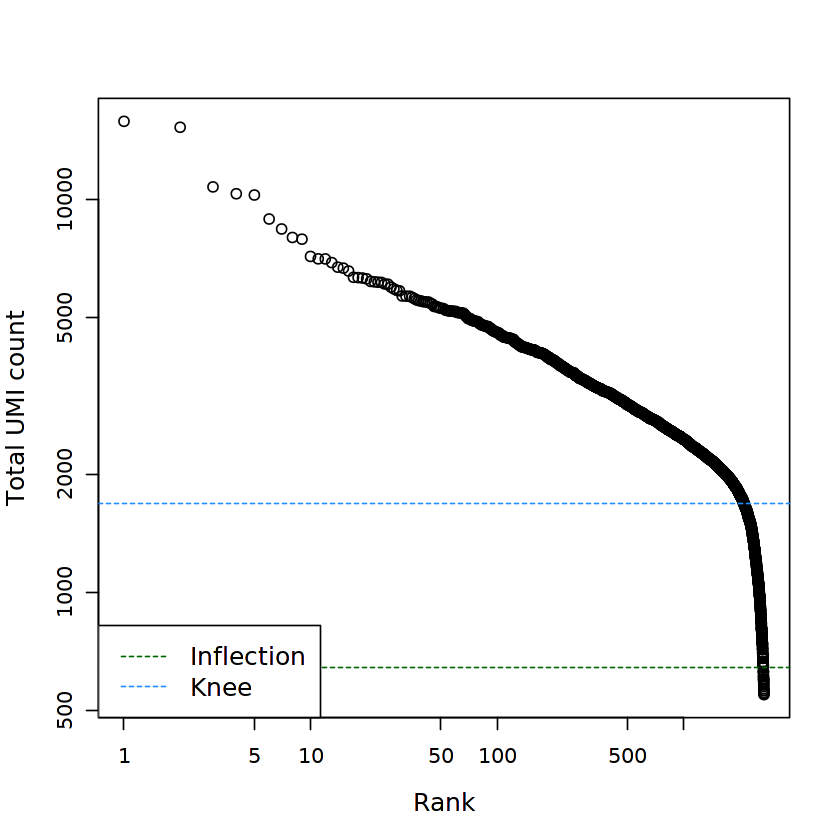

In [58]:
# Calling cells from empty droplets

bcrank <- barcodeRanks(counts(sce))

# Only showing unique points for plotting speed.
uniq <- !duplicated(bcrank$rank)
plot(bcrank$rank[uniq], bcrank$total[uniq], log="xy",
    xlab="Rank", ylab="Total UMI count", cex.lab=1.2)

abline(h=metadata(bcrank)$inflection, col="darkgreen", lty=2)
abline(h=metadata(bcrank)$knee, col="dodgerblue", lty=2)

legend("bottomleft", legend=c("Inflection", "Knee"), 
    col=c("darkgreen", "dodgerblue"), lty=2, cex=1.2)

In [67]:
unfiltered <- sce
#sce <- unfiltered

In [69]:
mito <- which(rowData(sce)$SEQNAME=="MT")
stats <- perCellQCMetrics(sce, subsets=list(Mt=mito))

In [72]:
high.mito <- isOutlier(stats$subsets_Mito_percent, type="higher")
sce <- sce[,!high.mito]

ERROR: Error in split.default(M, B):  最初の引数はベクトルでなくてはなりません 


In [70]:
sce <- sce[,!qc$discard]

DataFrame with 2700 rows and 6 columns
           sum  detected subsets_Mt_sum subsets_Mt_detected subsets_Mt_percent
     <numeric> <integer>      <numeric>           <integer>          <numeric>
1         2421       781              0                   0                  0
2         4903      1352              0                   0                  0
3         3149      1131              0                   0                  0
4         2639       960              0                   0                  0
5          981       522              0                   0                  0
...        ...       ...            ...                 ...                ...
2696      3461      1155              0                   0                  0
2697      3447      1227              0                   0                  0
2698      1684       622              0                   0                  0
2699      1024       454              0                   0                  0
2700      198

In [75]:
library(scuttle)
is.mito <- grep("^MT-", rowData(sce)$Symbol)
pbmc.qc <- perCellQCMetrics(sce, subsets=list(MT=is.mito))
discard.mito <- isOutlier(pbmc.qc$subsets_MT_percent, type="higher")
summary(discard.mito)

   Mode   FALSE    TRUE 
logical    2607      93 

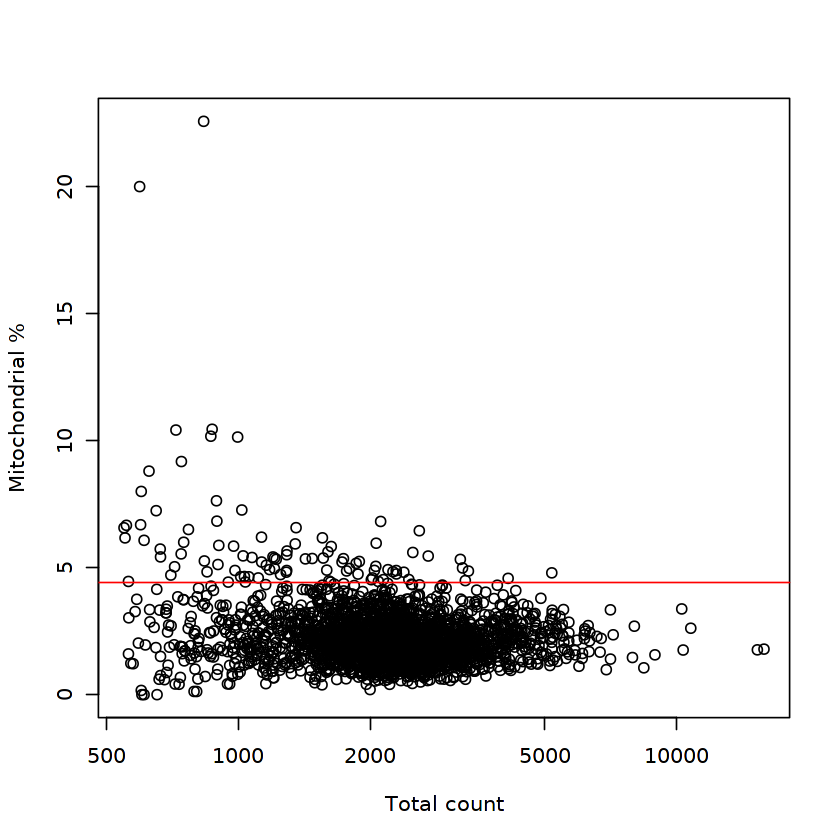

In [76]:
plot(pbmc.qc$sum, pbmc.qc$subsets_MT_percent, log="x",
    xlab="Total count", ylab='Mitochondrial %')
abline(h=attr(discard.mito, "thresholds")["higher"], col="red")

In [43]:
rowRanges(sce) # empty

GRangesList object of length 32738:
$ENSG00000243485
GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: no sequences

$ENSG00000237613
GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: no sequences

$ENSG00000186092
GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: no sequences

...
<32735 more elements>

In [52]:
# Let's use annotation 

hg19.gtf <- bfcrpath(bfc, file.path("http://ftp.ensembl.org/pub/release-55",
    "gtf/homo_sapiens/Homo_sapiens.GRCh37.55.gtf.gz"))

ERROR: Error in h(simpleError(msg, call)):  引数 'x' の評価中にエラーが起きました (関数 'bfcrpath' に対するメソッドの選択時):  オブジェクト 'bfc' がありません  


In [19]:
fname <- file.path(data.dir = "data/filtered_gene_bc_matrices/hg19/")
sce.pbmc <- read10xCounts(fname, col.names=TRUE)

In [20]:
sce.pbmc

class: SingleCellExperiment 
dim: 32738 2700 
metadata(1): Samples
assays(1): counts
rownames(32738): ENSG00000243485 ENSG00000237613 ... ENSG00000215616
  ENSG00000215611
rowData names(2): ID Symbol
colnames(2700): AAACATACAACCAC-1 AAACATTGAGCTAC-1 ... TTTGCATGAGAGGC-1
  TTTGCATGCCTCAC-1
colData names(2): Sample Barcode
reducedDimNames(0):
altExpNames(0):

In [22]:
library(scater)
rownames(sce.pbmc) <- uniquifyFeatureNames(
    rowData(sce.pbmc)$ID, rowData(sce.pbmc)$Symbol)

In [23]:
library(EnsDb.Hsapiens.v75)
location <- mapIds(EnsDb.Hsapiens.v75, keys=rowData(sce.pbmc)$ID, 
    column="SEQNAME", keytype="GENEID")

In [24]:
set.seed(100)
e.out <- emptyDrops(counts(sce.pbmc))
sce.pbmc <- sce.pbmc[,which(e.out$FDR <= 0.001)]

ERROR: Error in .compute_ambient_stats(m, totals, lower = lower): no counts available to estimate the ambient profile


In [10]:
#library(SummarizedExperiment)
library(scater)

rowData(pbmc)

Loading required package: SingleCellExperiment



ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘rowData’ for signature ‘"Seurat"’


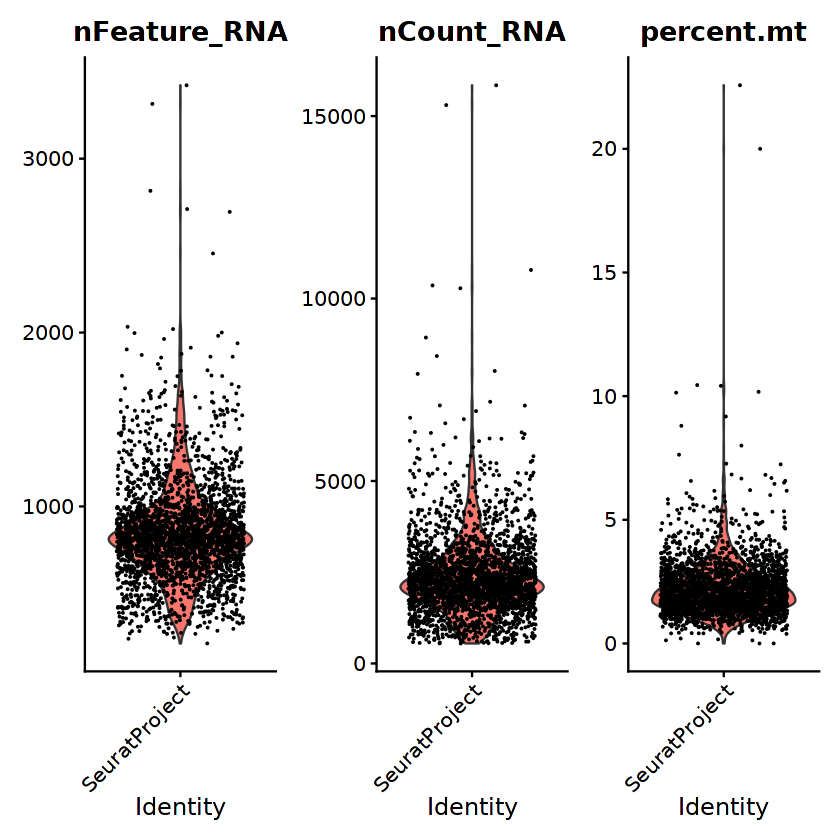

In [4]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- addPer

In [ ]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

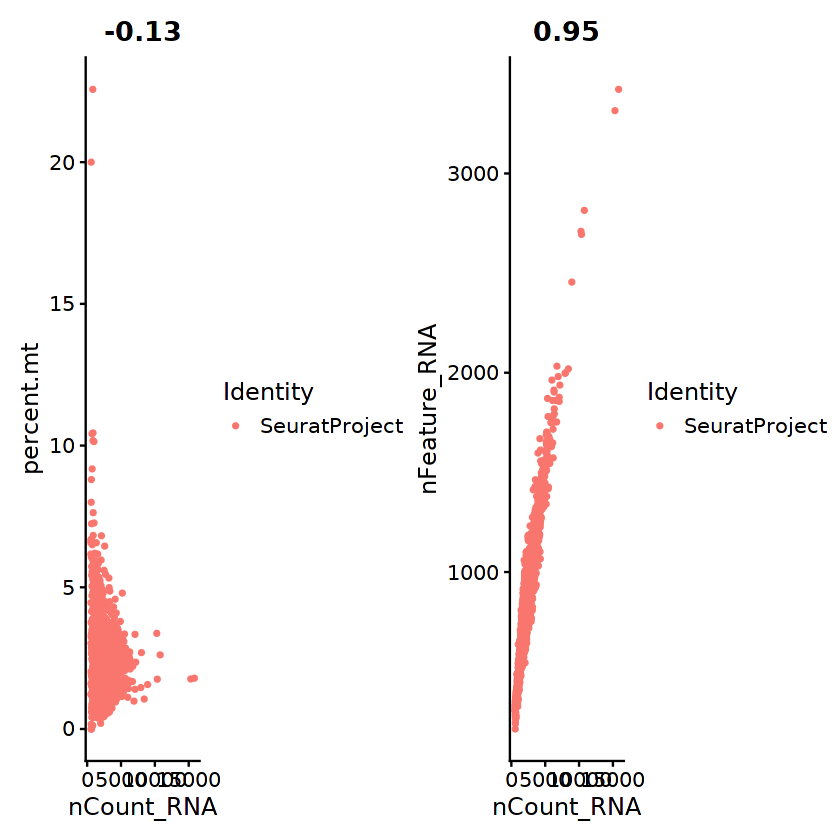

In [5]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [6]:
pbmc <- SCTransform(pbmc, method = "glmGamPoi", vars.to.regress = "percent.mt", verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


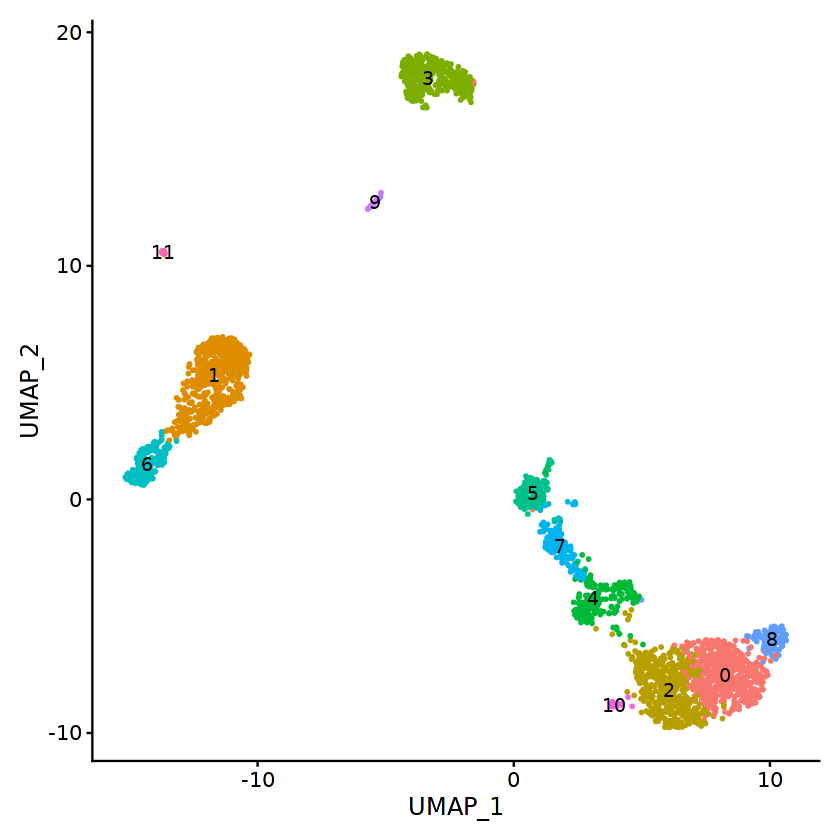

In [7]:
# These are now standard steps in the Seurat workflow for visualization and clustering
pbmc <- RunPCA(pbmc, verbose = FALSE)
pbmc <- RunUMAP(pbmc, dims = 1:30, verbose = FALSE)

pbmc <- FindNeighbors(pbmc, dims = 1:30, verbose = FALSE)
pbmc <- FindClusters(pbmc, verbose = FALSE)


DimPlot(pbmc, label = TRUE) + NoLegend()

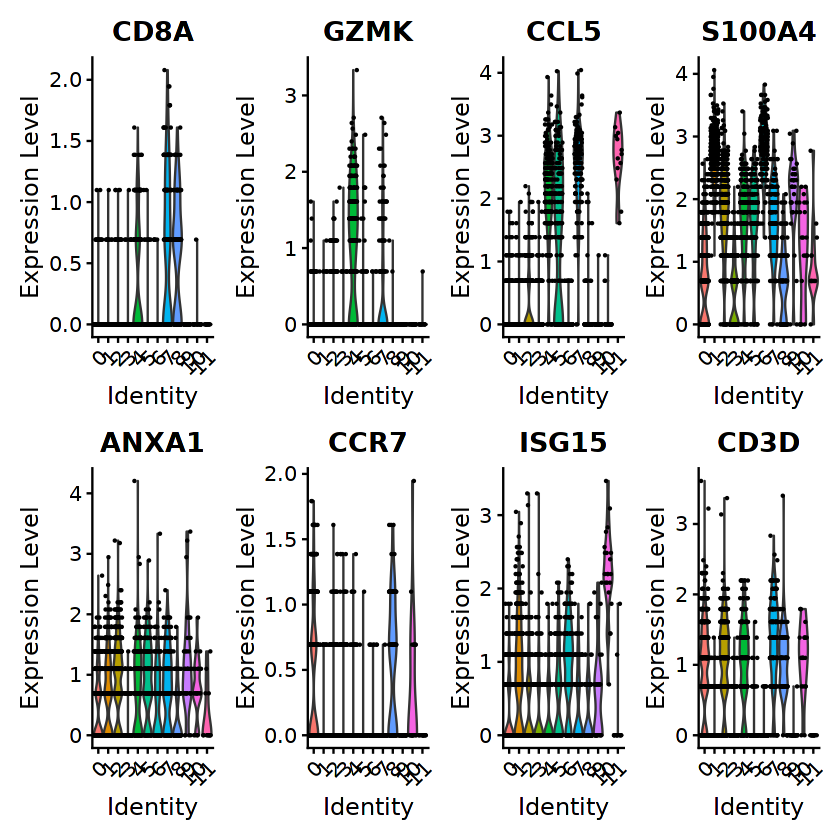

In [8]:
# These are now standard steps in the Seurat workflow for visualization and clustering
# Visualize canonical marker genes as violin plots.
VlnPlot(pbmc, features = c("CD8A", "GZMK", "CCL5", "S100A4", "ANXA1", "CCR7", "ISG15", "CD3D"),
    pt.size = 0.2, ncol = 4)

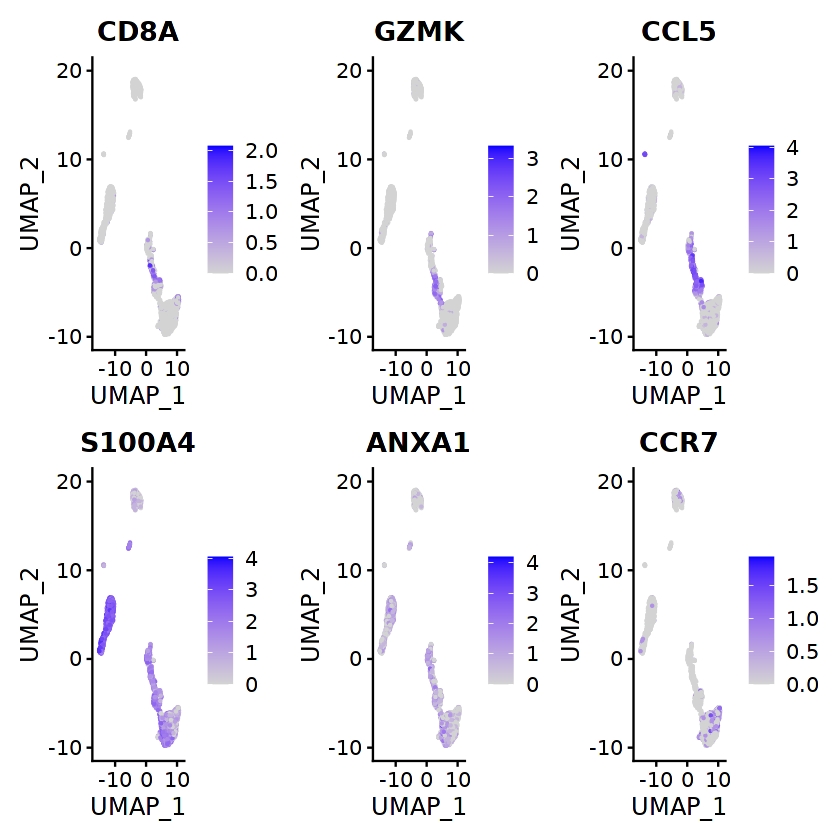

In [9]:
# Visualize canonical marker genes on the sctransform embedding.
FeaturePlot(pbmc, features = c("CD8A", "GZMK", "CCL5", "S100A4", "ANXA1", "CCR7"), pt.size = 0.2,
    ncol = 3)

In [10]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.017737e-95,0.7533227,0.951,0.591,1.279499e-91,0,LDHB
3.119715e-97,0.7181490,1.000,0.983,3.922106e-93,0,RPS3A
0.000000e+00,4.3920339,0.992,0.208,0.000000e+00,1,S100A9
3.686216e-277,3.9669171,1.000,0.532,4.634311e-273,1,LYZ
2.086907e-107,1.3294009,0.978,0.646,2.623659e-103,2,LTB
3.299574e-103,1.0361613,0.948,0.471,4.148224e-99,2,IL32
6.520104e-191,2.6152340,1.000,0.839,8.197075e-187,3,CD74
0.000000e+00,2.4113075,0.929,0.037,0.000000e+00,3,CD79A
2.549686e-139,2.0571390,0.964,0.243,3.205465e-135,4,CCL5


Warning message in DoHeatmap(pbmc, features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: RPS25, RPL31”


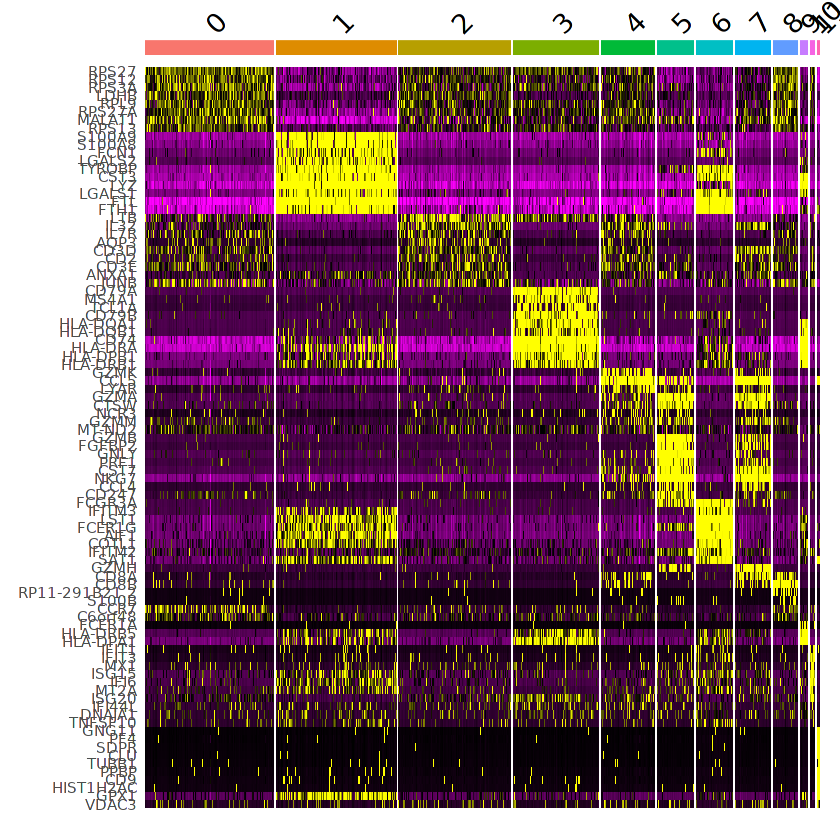

In [11]:
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

In [13]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] sctransform_0.3.2  ggplot2_3.3.5      dplyr_1.0.7        patchwork_1.1.1   
[5] SeuratObject_4.0.2 Seurat_4.0.4      

loaded via a namespace (and not attached):
  [1] Rtsne_0.15                  colorspace_2.0-2           
  [3] deldir_0.2-10               elli